In [1]:
#!pip install langdetect
#!pip install scattertext
#!pip install spacy

In [1]:
import pandas as pd
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import os 
import re
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import spacy
import scattertext as st
import nltk
from nltk.corpus import stopwords

In [20]:
sw = stopwords.words("english")

## Load Data

In [2]:
df = pd.read_excel('./data/fake_job_postings.xlsx')

## Cleaning 
- Replace null to string "missing" -- instead of dropping missings, use as a valid observation. Could be that fake posts often have missing fields
- Separate country, state, city from location
- Drop non-english text entries
- Clean text columns: separate sentences, remove URLs, non-ascii, punctuation, extra spaces and white space
- Redefine education bins
- Drop salary range: very often missing, unsure what units are used in foreign countries, inconsistent time frame (hourly, monthly, yearly)

In [3]:
# replace null to "missing"
for c in df.columns:
    df[c] = np.where(df[c].isnull(), 'missing', df[c])

In [4]:
# separate location attributes
df['country'] = df.location.str.split(',').str[0]
df['state'] = df.location.str.split(', ').str[1]
df['city'] = df.location.str.split(', ').str[2]

In [5]:
# drop non-english postings
df['language'] = df['description'].apply(lambda x: detect(x))
df = df[df.language == 'en']

In [6]:
# spot cleanup for nyc abbreviations
df.city = np.where(df.city == 'nyc', 'new york city', df.city)
df.city = np.where(df.city == 'ny', 'new york city', df.city)
df.city = np.where(df.city == 'new york', 'new york city', df.city)

In [7]:
# text cleaning 
text_columns = ['country', 'state', 'city', 'title', 'department', 'company_profile', 'description', 'requirements',
               'benefits', 'required_experience', 'employment_type', 'required_education', 'industry', 'function']
for c in text_columns:
    df[c] = df[c].apply(lambda x: re.sub(r'â€™', '', str(x))) # remove specific character used for apostrophe
                                                              # replace with '' before ascii removal so contractions together
    df[c] = df[c].str.replace('([A-Z])((?=[a-z]))', r' \1') # if lower case followed by upper case, separate by space
                                                            # works for a.A as well 
    df[c] = df[c].str.lower() # downcase 
    df[c] = np.where(df[c] == '', 'missing', df[c]) # empty strings mark as missing
    df[c] = df[c].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in str(x)])) # remove non-ascii
    df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub(r'[^\w\s]','', x)) # remove punctuation. Replace with '' so don't separate contractions
    df[c] = df[c].apply(lambda x: re.sub(' +', ' ', x)) # remove double and triple spaces
    df[c] = df[c].apply(lambda x: str(x).strip()) # remove white space trailing/leading

In [8]:
# redefine education bins
df['education_bin'] = np.where(df.required_education.isin(['some high school coursework']),
                               'less than high school', df.required_education)
df.education_bin = np.where(df.required_education.isin(['high school or equivalent']), 'high school', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['vocational hs diploma', 'vocational degree',
                                                       'vocational']), 'vocational', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['some college coursework completed']), 'some college', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['unspecified']), "missing", df.education_bin)

In [9]:
# drop salary range variable 
del df['salary_range']

## EDA

In [10]:
df.fraudulent = pd.to_numeric(df.fraudulent)

__Bar Plots of Metadata Frequency in Fraudulent Posts__

In [12]:
def bar_plt(col, titlecol, boolean = False):
    
    # count number of fraudulent postings and total postings -> calculate fraction of postings that are fraud
    fraudcnt = df.groupby(col).fraudulent.sum().to_frame()
    totcnt = df.groupby(col).job_id.count().to_frame()
    frac = pd.merge(fraudcnt, totcnt, left_index = True, right_index = True)
    frac['frac'] = frac.fraudulent / frac.job_id 
    
    # exclude if fewer than 10 total postings (else fraction may be close to 100%)
    frac = frac[frac.job_id > 10]
    
    # sort and take top 10 
    frac['index_col'] = frac.index
    frac = frac.reset_index(drop = True)
    if boolean == False:
        frac = frac.sort_values('frac').tail(10)

    # plot
    cnt = len(frac)
    sns.barplot(x='index_col', y="frac", data=frac, order=frac['index_col'])
    if boolean == False:
        plt.xticks(rotation=90)
    else:
        plt.xticks([0, 1], ['No', 'Yes'])
        
    if cnt == 10:
        plt.title('Top 10 ' + titlecol + ' by Percent Fraudulent Postings')
    else:
        plt.title(titlecol + ' by Percent Fraudulent Postings')
        
    plt.ylabel('Fraction of Fraudulent Postings')
    plt.xlabel('')

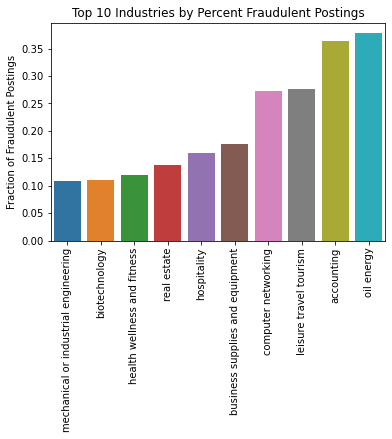

In [13]:
bar_plt('industry', 'Industries')

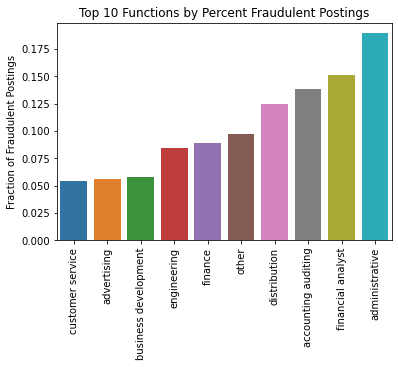

In [14]:
bar_plt('function', 'Functions')

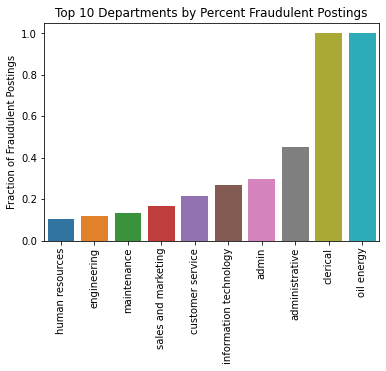

In [15]:
bar_plt('department', 'Departments')
# clerical and oil energy appear to be the same handful of job postings posted many times with different locations or titles

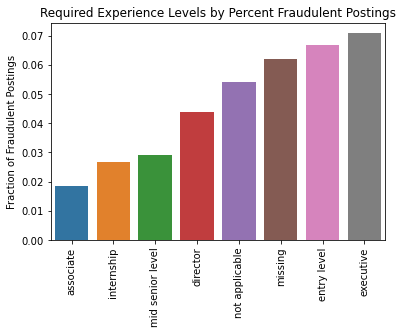

In [16]:
bar_plt('required_experience', 'Required Experience Levels')

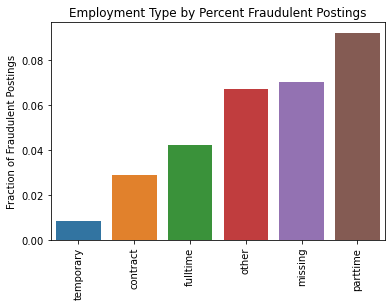

In [17]:
bar_plt('employment_type', 'Employment Type')

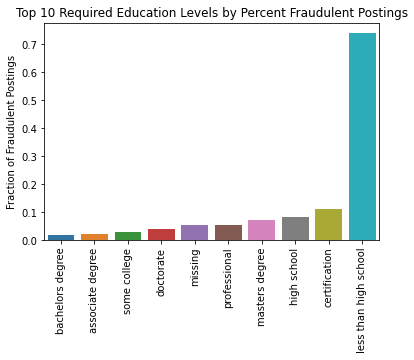

In [18]:
bar_plt('education_bin', 'Required Education Levels')

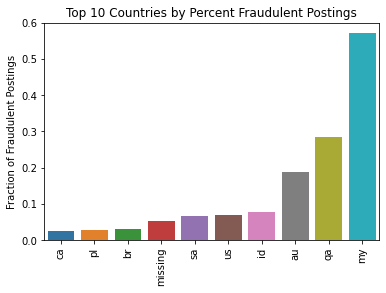

In [19]:
bar_plt('country', 'Countries')

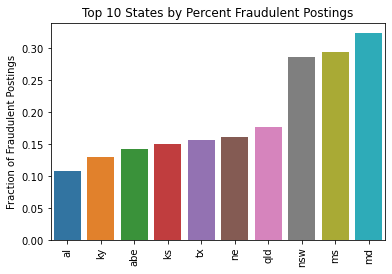

In [20]:
bar_plt('state', 'States')

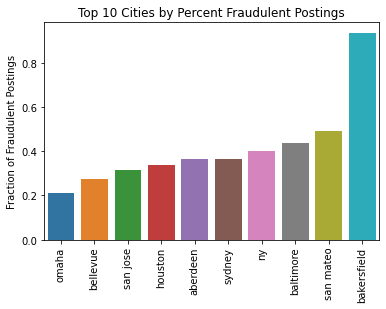

In [21]:
bar_plt('city', 'Cities')

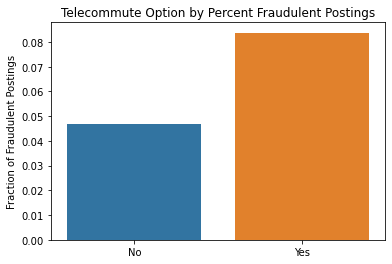

In [22]:
bar_plt('telecommuting', 'Telecommute Option', boolean = True)

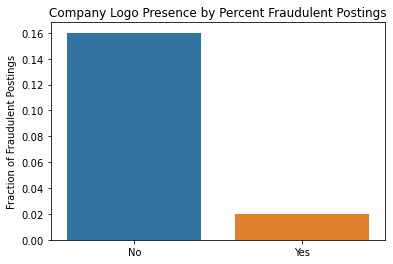

In [23]:
bar_plt('has_company_logo', 'Company Logo Presence', boolean = True)

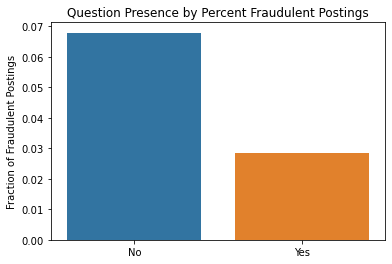

In [24]:
bar_plt('has_questions', 'Question Presence', boolean = True)

__Visualize Common Words in Fake vs Real Postings using Scattertext__   
Tokenize and remove stop words. Don't bother with lemmatization for exploratory analysis + interferes with ability to see examples using scattertext interactive html

In [56]:
nlp = spacy.load('en')

In [25]:
# run in terminal (with admina priviledges): 'py -m spacy download en'
#nltk.download('stopwords')

In [11]:
df['fraudulent_words'] = np.where(df.fraudulent == 1, 'fake', 'real')

In [27]:
def scattertext_visualize(col):
    
    df['parse'] = df[col].apply(st.whitespace_nlp_with_sentences)
    
    corpus = st.CorpusFromParsedDocuments(
        df, category_col='fraudulent_words', parsed_col='parse'
    ).build().get_unigram_corpus().compact(st.AssociationCompactor(2000)).remove_terms(sw, ignore_absences=True)

    html = st.produce_scattertext_explorer(
        corpus,
        category='fake', category_name='Fraudulent', not_category_name='Real',
        minimum_term_frequency=0, pmi_threshold_coefficient=0,
        width_in_pixels=1000,
        transform=st.Scalers.dense_rank,
        metadata=corpus.get_df()['title']
    )
    open('./scattertext_' + col + '.html', 'w').write(html)

In [28]:
nlp_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for c in nlp_columns:
    scattertext_visualize(c)

## Topic Modeling

- Tokenize, remove stop words, lemmatize based on POS 

In [76]:
# combine text fields into single string 
for c in ['title', 'company_profile', 'description', 'requirements', 'benefits']:
    df[c] = np.where(df[c] == 'missing', '', df[c])
    
df['text'] = df.title + ' ' + df.company_profile + ' ' + df.description + ' ' + df.requirements + ' ' + df.benefits

In [77]:
# function from
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [78]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 12:09:45


In [79]:
# tokenize
df.text = df.text.apply(lambda row: row.split(' '))
# remove stop words
df.text = df.text.apply(lambda row: [w for w in row if w not in sw])

# convert into list 
text = df.text.values.tolist()

# lemmatize and remove proper nouns 
# ex removing company names. Not important for topic modeling. 
text = lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [80]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 12:20:41


In [81]:
# save text string
with open('textlst.pkl', 'wb') as f:
    pickle.dump(text, f)

In [61]:
#with open('textlst.pkl', 'rb') as f:
#    lst = pickle.load(f)